In [1]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"):
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

xn, xx, yn, yx = [125,146,30,46]  # larger region for data retrieval
xn, xx, yn, yx = [125,133,30,40]  # smaller region for plotting

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/korea-fires/"

mapproj = cartopy.crs.PlateCarree()

def scale(ts): return (ts - ts.mean()) / ts.std()

In [2]:
sf_korea = gpd.read_file("sf_korea")
sf_ekorea = gpd.read_file("sf_ekorea")
sf_kyushu = gpd.read_file("sf_kyushu")

adm1 = gpd.read_file("sf_adm1")

# TO DO
- download climate model data
- check trends in monthly VPD vs daily (& compute VPD from monthly mean if necessary)
- formal trend fitting for ERA5-land HDWI (1970 onwards)
- formal trend analysis for precip (ERA5, CPC, CHIRPS - stations?)
- fit trend to gridded data?
- changes in seasonal cycle?

# MODIS active fire data

## Compile & filter active fire data

In [25]:
px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])

In [ ]:
fig, axs = plt.subplots(ncols = 3, figsize = (3*4.5, 6), dpi = 100, subplot_kw = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})

for i in range(3):
    ax = axs[i]
    ax.coastlines()
    
    px_m = px.loc["2025-0"+str(i+1)]
    ax.scatter(px_m.longitude, px_m.latitude, color = "firebrick", marker = ".")
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom", "left"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.set_title("2025-0"+str(i+1))
    sf_ekorea.boundary.plot(ax = ax, color = "darkgreen", alpha = 0.3)

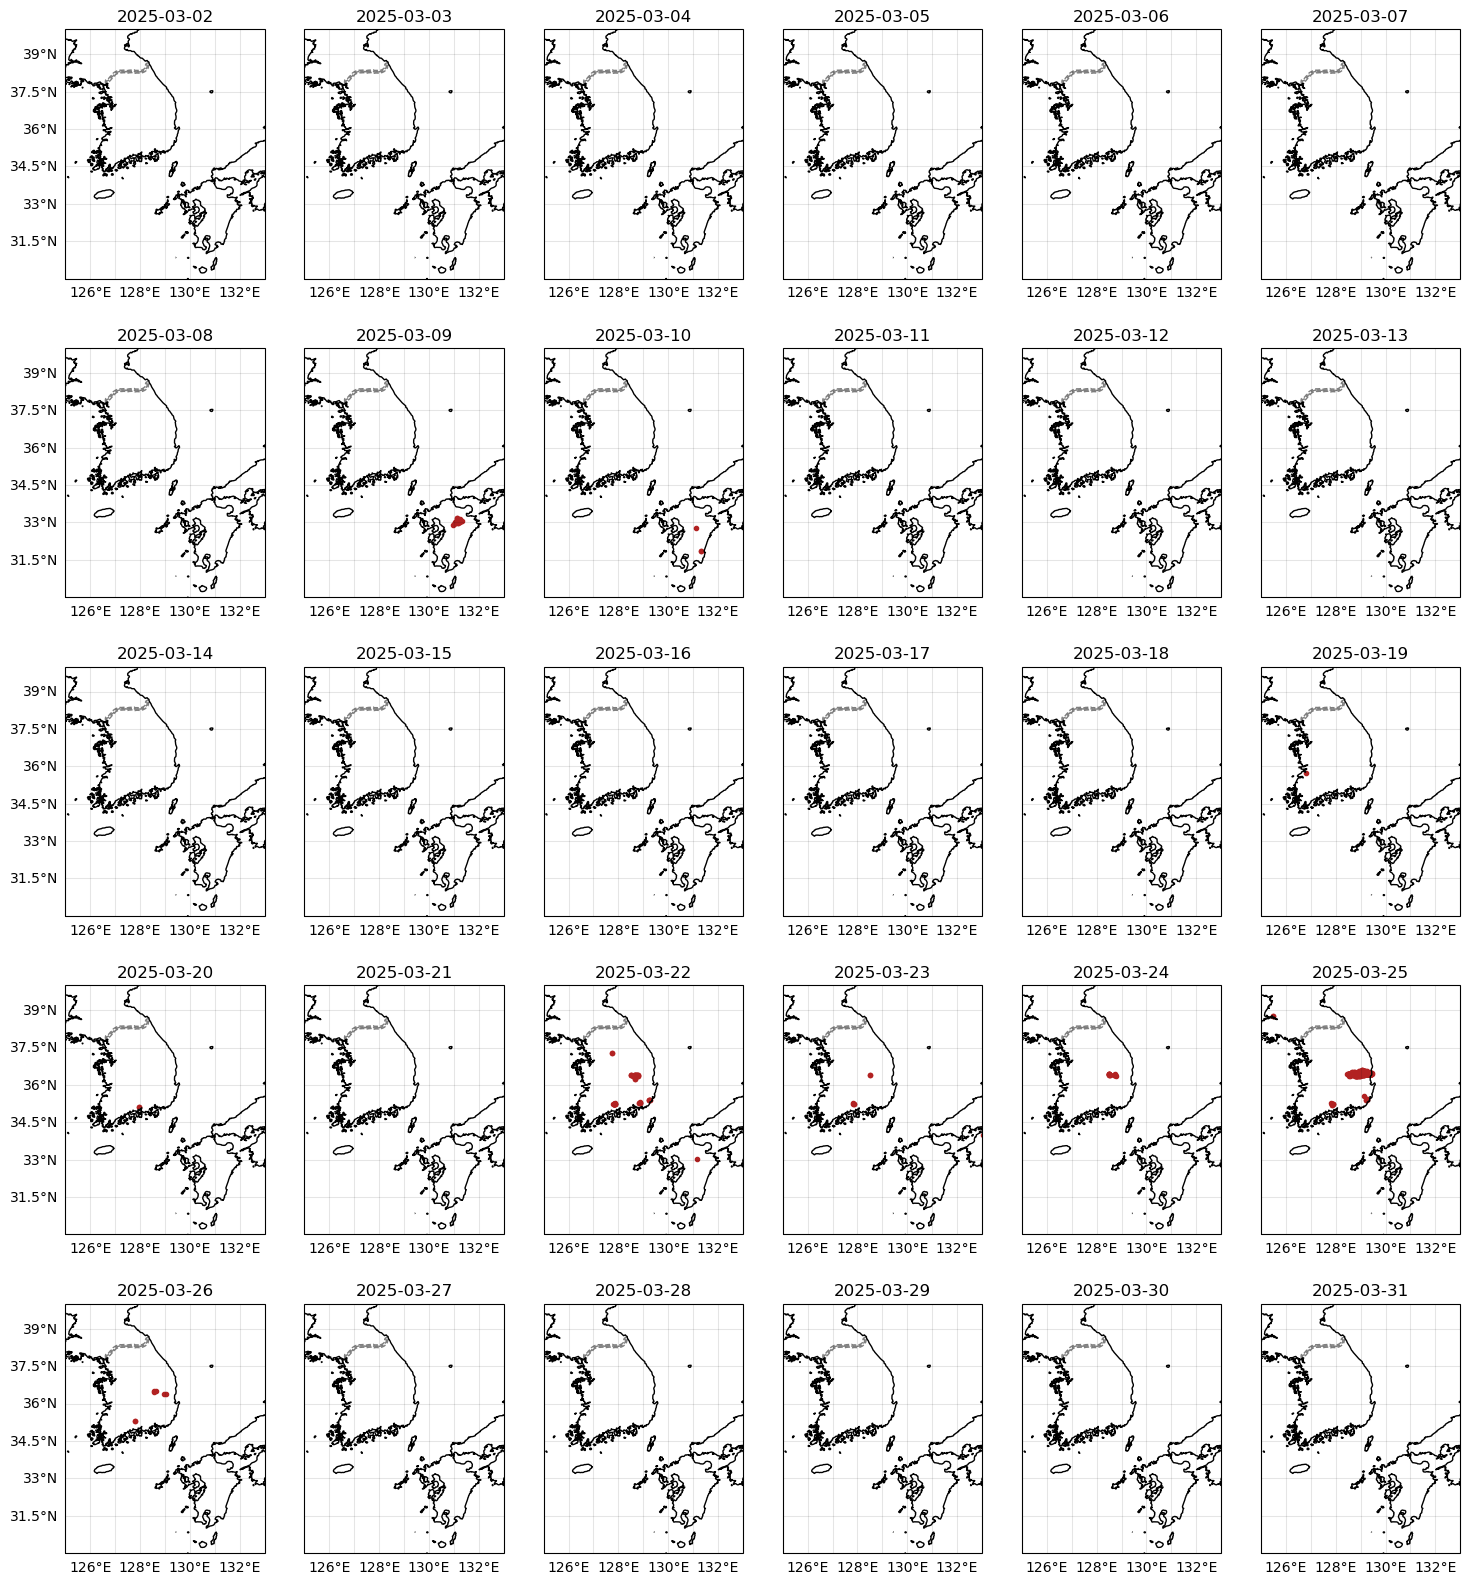

In [11]:
# smaller region for plotting
xn, xx, yn, yx = [125,133,30,40]

nc = 6; nr = 5
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*3, nr*4), dpi = 100, subplot_kw = {"projection" : mapproj, "extent": [xn,xx,yn,yx]}, sharey = True)

for i in range(30):
    ax = axs.flatten()[i]
    
    d = "2025-03-"+str(i+2).rjust(2,"0")
    
    if d in px.index:
        px_d = px.loc[d]
        ax.scatter(px_d.longitude, px_d.latitude, color = "firebrick", marker = ".")
        
    ax.coastlines()
    ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["bottom"])
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
    ax.set_title(d)
    
for ax in axs[:,0]: ax.gridlines(color = "k", alpha = 0, draw_labels = ["left"])
    
plt.savefig("fig/modis-activefires_march2025.png")

# Seasonal figures

In [3]:
fwi = xr.open_dataset("data/fwi_era5_201301-202501.nc")
rm_kr = regionmask.mask_geopandas(sf_korea, fwi.lon, fwi.lat)
rm_ekr = regionmask.mask_geopandas(sf_ekorea, fwi.lon, fwi.lat)
rm_kyu = regionmask.mask_geopandas(sf_kyushu, fwi.lon, fwi.lat)

fwi_kr = fwi.where(rm_kr == 0, drop = True).mean(["lat", "lon"])
fwi_ekr = fwi.where(rm_ekr == 0, drop = True).mean(["lat", "lon"])
fwi_kyu = fwi.where(rm_kyu == 0, drop = True).mean(["lat", "lon"])

fwi_vars = xr.open_dataset("data/fwi-vars_era5_201301-202501.nc")
fwivars_kr = fwi_vars.where(rm_kr == 0, drop = True).mean(["lat", "lon"])
fwivars_ekr = fwi_vars.where(rm_ekr == 0, drop = True).mean(["lat", "lon"])
fwivars_kyu = fwi_vars.where(rm_kyu == 0, drop = True).mean(["lat", "lon"])

In [5]:
vpdmax = xr.open_dataset("data/vpdmax_era5land_198101-202503.nc").vpdmax
sfcWindmax = xr.open_dataset("data/sfcWindmax_era5land_198101-202503.nc").sfcWindmax
tasmax = xr.open_dataset("data/tasmax_era5land_198101-202503.nc").tasmax
hdwi = (vpdmax * sfcWindmax).rename("hdwi")
ds_hdwi = xr.merge([hdwi, vpdmax, sfcWindmax, tasmax])

rm_kr = regionmask.mask_geopandas(sf_korea, ds_hdwi.longitude, ds_hdwi.latitude)
rm_ekr = regionmask.mask_geopandas(sf_ekorea, ds_hdwi.longitude, ds_hdwi.latitude)
rm_kyu = regionmask.mask_geopandas(sf_kyushu, ds_hdwi.longitude, ds_hdwi.latitude)


hdwi_kr = ds_hdwi.where(rm_kr == 0, drop = True).mean(["latitude", "longitude"])
hdwi_ekr = ds_hdwi.where(rm_ekr == 0, drop = True).mean(["latitude", "longitude"])
hdwi_kyu = ds_hdwi.where(rm_kyu == 0, drop = True).mean(["latitude", "longitude"])

In [6]:
rnm = "Kyushu"

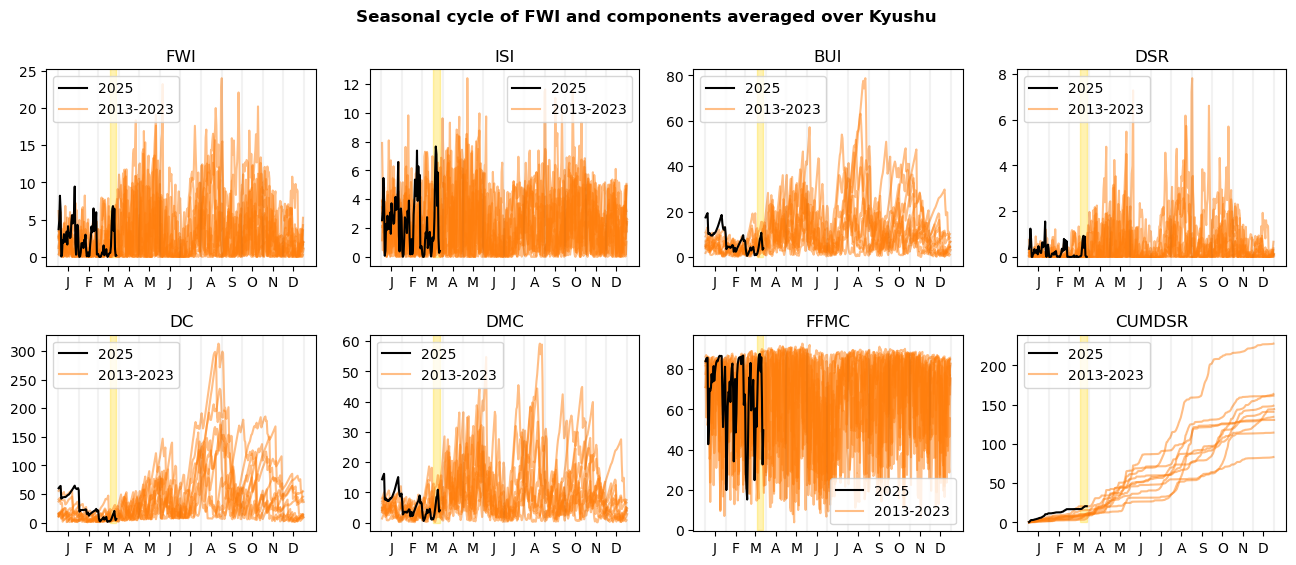

In [7]:
nc = 4; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

fwi_ts = {"Korea" : fwi_kr, "Eastern Korea" : fwi_ekr, "Kyushu" : fwi_kyu}[rnm]

fwi_ts = fwi_ts.assign_coords(offset_time = ("time", fwi_ts.time.shift(time = 0).data)) # shift time for offset axes
fwi_ts["cumDSR"] = fwi_ts.dsr.resample(time = "AS-JAN").cumsum()

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

varbls = ["fwi", "isi", "bui", "dsr", "dc", "dmc", "ffmc", "cumDSR"]
for i in range(len(varbls)):
    ax = axs.flatten()[i]
    varnm = varbls[i]
    
    ts = fwi_ts[varnm]
    y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2013,2023):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
    ax.set_title(varnm.upper())
    
    ax.legend(["2025", "2013-2023"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.suptitle("Seasonal cycle of FWI and components averaged over "+rnm, fontweight = "bold")
plt.savefig("fig/ev-seasonal_fwi_"+"-".join(rnm.lower().split(" ")))

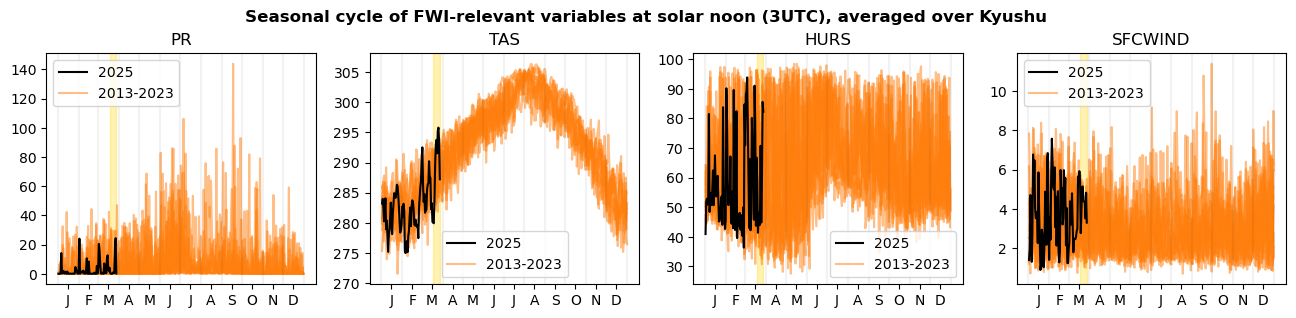

In [9]:
nc = 4; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

fwi_ts = {"Korea" : fwivars_kr, "Eastern Korea" : fwivars_ekr, "Kyushu" : fwivars_kyu}[rnm]

fwi_ts = fwi_ts.assign_coords(offset_time = ("time", fwi_ts.time.shift(time = 0).data)) # shift time for offset axes

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

varbls = ["pr", "tas", "hurs", "sfcWind"]
for i in range(len(varbls)):
    ax = axs.flatten()[i]
    varnm = varbls[i]
    
    ts = fwi_ts[varnm]
    y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(2013,2023):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
    ax.set_title(varnm.upper())
    
    ax.legend(["2025", "2013-2023"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.suptitle("Seasonal cycle of FWI-relevant variables at solar noon (3UTC), averaged over "+rnm, fontweight = "bold", y = 1.025)
plt.savefig("fig/ev-seasonal_fwivars_"+"-".join(rnm.lower().split(" ")))

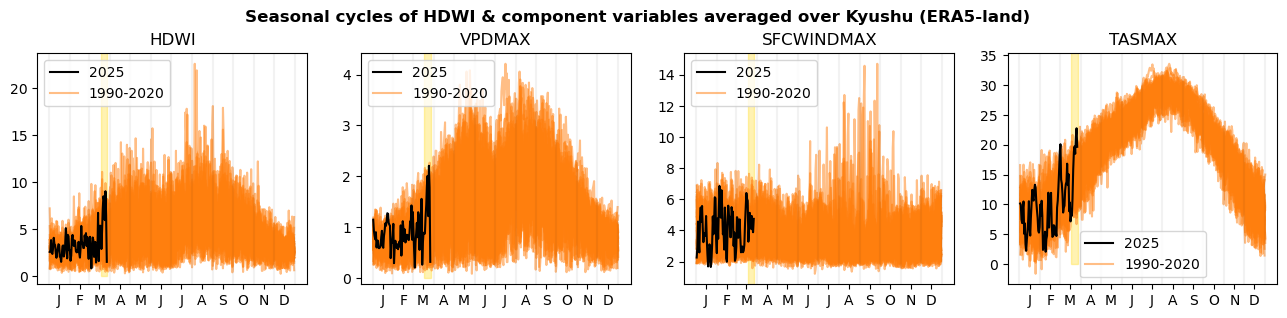

In [10]:
nc = 4; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

fwi_ts = {"Korea" : hdwi_kr, "Eastern Korea" : hdwi_ekr, "Kyushu" : hdwi_kyu}[rnm]

fwi_ts = fwi_ts.assign_coords(offset_time = ("time", fwi_ts.time.shift(time = 0).data)) # shift time for offset axes

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

varbls = ["hdwi", "vpdmax", "sfcWindmax", "tasmax"]
for i in range(len(varbls)):
    ax = axs.flatten()[i]
    varnm = varbls[i]
    
    ts = fwi_ts[varnm]
    y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(1990,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")
    
    ax.set_title(varnm.upper())
    
    ax.legend(["2025", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.suptitle("Seasonal cycles of HDWI & component variables averaged over "+rnm+" (ERA5-land)", fontweight = "bold", y = 1.025)
plt.savefig("fig/ev-seasonal_hdwi_"+"-".join(rnm.lower().split(" ")))

## Accumulations

### HDWI

In [348]:
hdwi = xr.open_dataset("data/hdwi_era5land_198101-202503.nc")
hdwi = hdwi.assign_coords(offset_time = ("time", hdwi.time.shift(time = 0).data)) # shift time if seasonal cycle needs to be moved

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

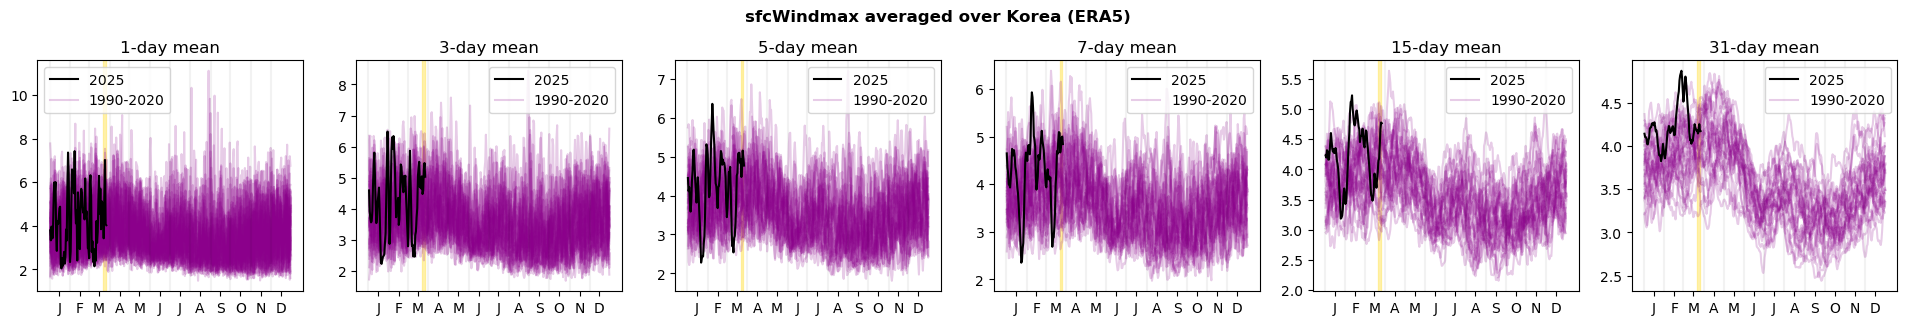

In [352]:
rnm = "Korea"
varnm = "sfcWindmax"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
rm = regionmask.mask_geopandas(sf, hdwi.lon, hdwi.lat)
ts = hdwi[varnm].where(rm == 0, drop = True).mean(["lat", "lon"])

col = {"hdwi" : "firebrick", "tasmax" : "tab:orange", "vpdmax" : "mediumpurple", "sfcWindmax" : "darkmagenta"}[varnm]

ndays = [1,3,5,7,15,31]
nr = 1; nc = int(np.ceil(len(ndays)/nr));
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.25)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]
    
    ts_nday = ts.rolling(time = nd, center = False).mean()

    y = 2025; ts_y = ts_nday.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts_nday.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = col, alpha = 0.2, label = "_years")
    
    ax.set_title(str(nd)+"-day mean")
    
    ax.legend(["2025", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    d_start = ts.sel(time = "2025-03-22").offset_time.dt.dayofyear
    ax.add_patch(Rectangle((d_start, 0), 4, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.suptitle(varnm+" averaged over "+rnm+" (ERA5)", fontweight = "bold", y = 1.05)
plt.savefig("fig/nday_"+varnm+"_"+"-".join(rnm.lower().split(" ")))

### Precip

In [331]:
pr = xr.open_dataset("data/era5_tp_daily_extended_125-146E_30-46N.nc").tp
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data)) # shift time if seasonal cycle needs to be moved

days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

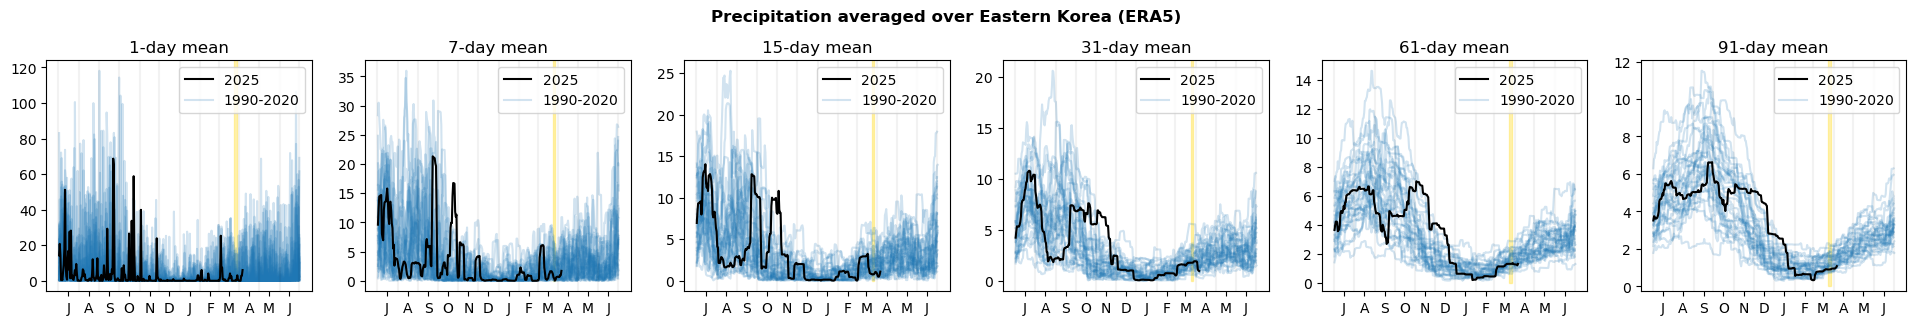

In [334]:
rnm = "Eastern Korea"

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
rm = regionmask.mask_geopandas(sf, pr.lon, pr.lat)
ts = pr.where(rm == 0, drop = True).mean(["lat", "lon"])

ndays = [1,7,15,31,61,91]
nr = 1; nc = int(np.ceil(len(ndays)/nr));
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.25)

for i in range(len(ndays)):
    ax = axs.flatten()[i]
    nd = ndays[i]
    
    ts_nday = ts.rolling(time = nd, center = False).mean()

    y = 2024; ts_y = ts_nday.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-25", zorder = 99)

    for y in range(1990,2020):
        ts_y = ts_nday.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.2, label = "_years")
    
    ax.set_title(str(nd)+"-day mean")
    
    ax.legend(["2025", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    d_start = ts.sel(time = "2025-03-22").offset_time.dt.dayofyear
    ax.add_patch(Rectangle((d_start, 0), 4, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.suptitle("Precipitation averaged over "+rnm+" (ERA5)", fontweight = "bold", y = 1.05)
plt.savefig("fig/nday_pr_"+"-".join(rnm.lower().split(" ")))

## Seasonal cycle

### Precip

In [32]:
pr = xr.open_dataset("data/era5_tp_daily_extended_125-146E_30-46N.nc").tp
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data)) # shift time if seasonal cycle needs to be moved

days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

Text(0.5, 1.05, 'Seasonal cycle of (15-day smoothed) precipitation in recent & past periods')

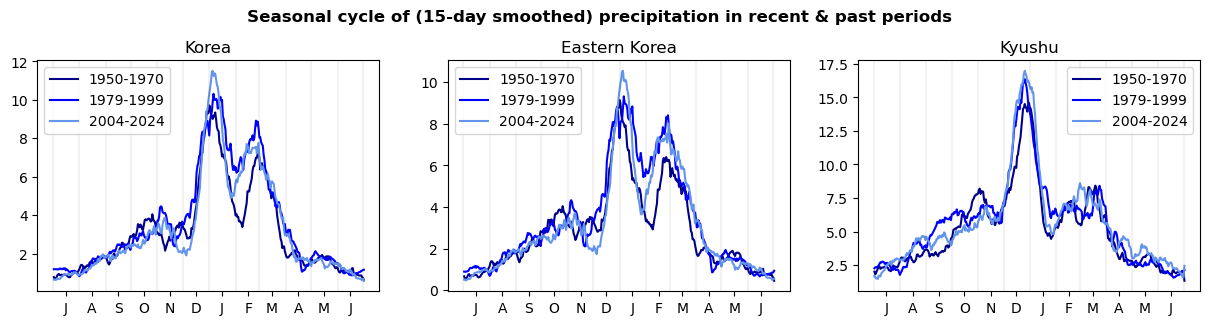

In [52]:
nc=3; nr=1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(3):
    rnm = ["Korea", "Eastern Korea", "Kyushu"][i]
    ax = axs[i]

    sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
    rm = regionmask.mask_geopandas(sf, pr.lon, pr.lat)
    ts = pr.where(rm == 0, drop = True).mean(["lat", "lon"]).rolling(time = 15, center = True).mean()

    sc_now = ts.sel(time = slice("2004","2024")).groupby("time.dayofyear").mean()
    sc_hist = ts.sel(time = slice("1979","1999")).groupby("time.dayofyear").mean()
    sc_1950 = ts.sel(time = slice("1950","1970")).groupby("time.dayofyear").mean()

    ax.plot(sc_hist.dayofyear, sc_1950, color = "darkblue", label = "1950-1970")
    ax.plot(sc_hist.dayofyear, sc_hist, color = "blue", label = "1979-1999")
    ax.plot(sc_now.dayofyear, sc_now, color = "cornflowerblue", label = "2004-2024")
    ax.set_title(rnm)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]
    
plt.suptitle("Seasonal cycle of (15-day smoothed) precipitation in recent & past periods", fontweight = "bold", y = 1.05)

### Tasmax

In [92]:
tx = xr.open_dataset("data/era5_tmax_daily_125-146E_30-46N_-999-lastyear_su.nc").tmax

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

Text(0.5, 1.05, 'Seasonal cycle of tasmax in recent & past periods (ERA5-Land)')

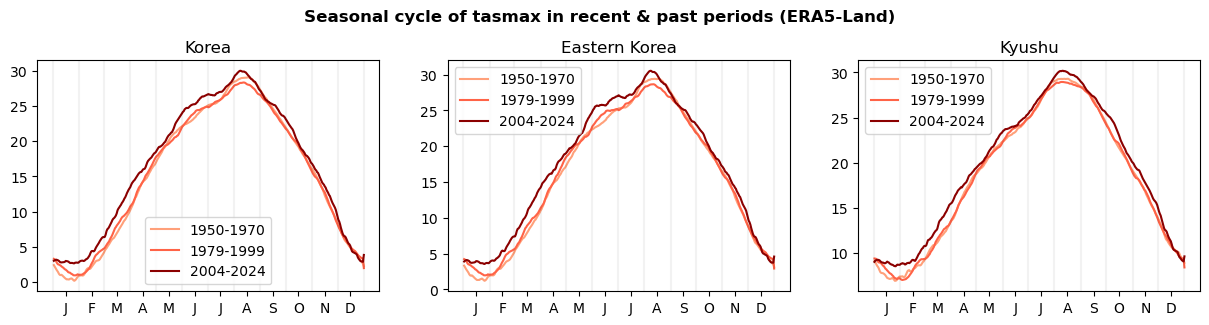

In [93]:
nc=3; nr=1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

for i in range(3):
    rnm = ["Korea", "Eastern Korea", "Kyushu"][i]
    ax = axs[i]

    sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
    rm = regionmask.mask_geopandas(sf, tx.lon, tx.lat)
    ts = tx.where(rm == 0, drop = True).mean(["lat", "lon"]).rolling(time = 15).mean()

    sc_now = ts.sel(time = slice("2014","2024")).groupby("time.dayofyear").mean()
    sc_hist = ts.sel(time = slice("1979","1999")).groupby("time.dayofyear").mean()
    sc_1950 = ts.sel(time = slice("1950","1970")).groupby("time.dayofyear").mean()

    ax.plot(sc_1950.dayofyear, sc_1950, color = "lightsalmon", label = "1950-1970")
    ax.plot(sc_hist.dayofyear, sc_hist, color = "tomato", label = "1979-1999")
    ax.plot(sc_now.dayofyear, sc_now, color = "darkred", label = "2004-2024")
#     ax.plot(sc_hist.dayofyear, sc_now - sc_hist)
    ax.set_title(rnm)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
plt.suptitle("Seasonal cycle of tasmax in recent & past periods (ERA5-Land)", fontweight = "bold", y = 1.05)

### Tasmax at stations

In [62]:
varnm = "pr"
df = merge_byindex([pd.read_csv(fnm, index_col = "date", parse_dates = ["date"])[[varnm]].rename(columns = {varnm : fnm.split("_")[2]}) for fnm in glob.glob("data/stations/*.csv")])

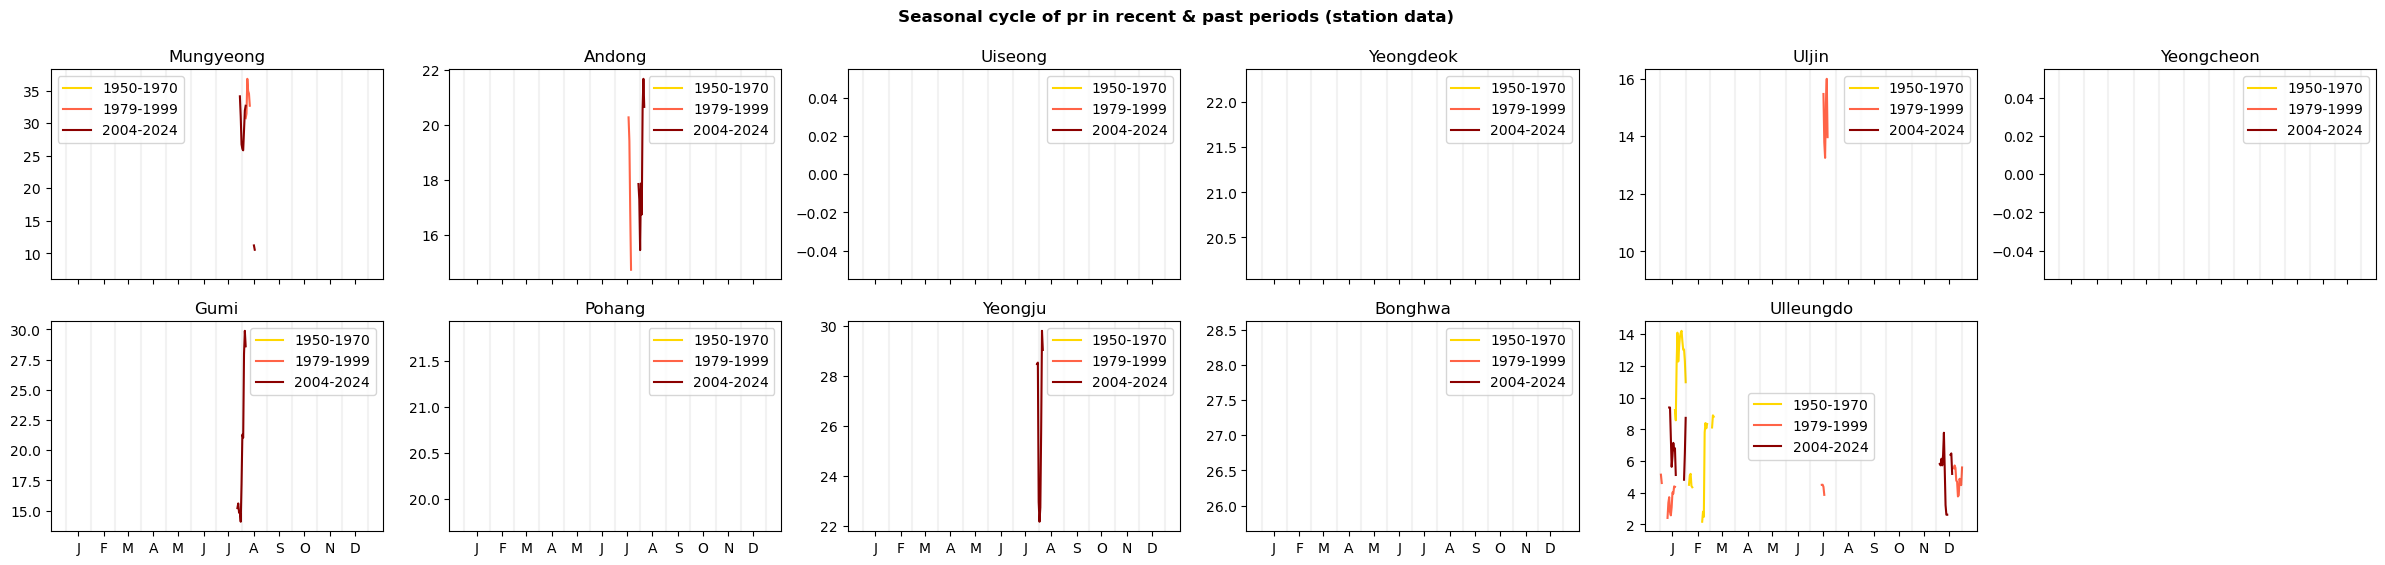

In [63]:
nc=6; nr=2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*5, nr*3), dpi = 100, sharex = True)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

for i in range(len(df.columns)):
    rnm = df.columns[i]
    ax = axs.flatten()[i]

    ts = df[[rnm]].rolling(15, center = True).mean()
    
    slices = [slice("1950","1970"), slice("1979","1999"), slice("2014", "2024")]
    
    ts_slices = [ts.loc[sl] for sl in slices]
    sc_slices = [sl.groupby(sl.index.dayofyear).mean() for sl in ts_slices]
    
    ax.set_title(rnm)
    
    for j in range(3):
        ax.plot(sc_slices[j].index, sc_slices[j], color = ["gold", "tomato", "darkred"][j], label = ["1950-1970", "1979-1999", "2004-2024"][j])
        
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
    plt.suptitle("Seasonal cycle of "+varnm+" in recent & past periods (station data)", fontweight = "bold")
    
for i in range(len(df.columns), nc*nr): axs.flatten()[i].set_axis_off()
plt.savefig("fig/station-sc_"+varnm+".png")

## Trend analysis

### HDWI - 5day max during March/March-April

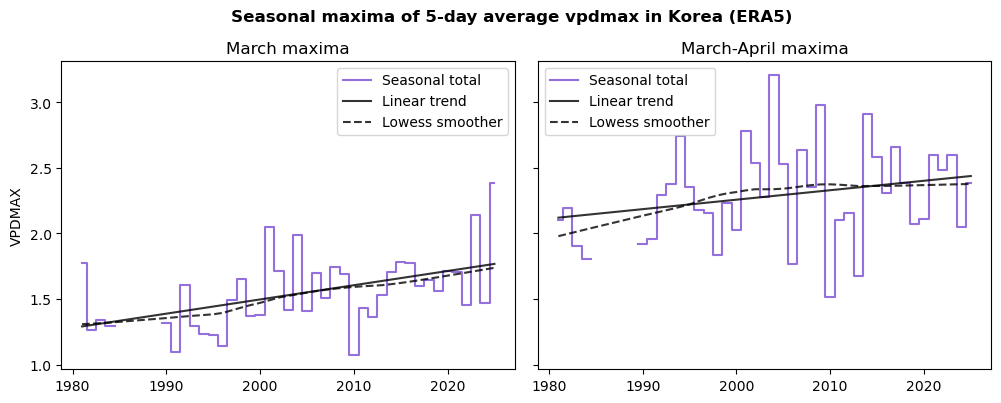

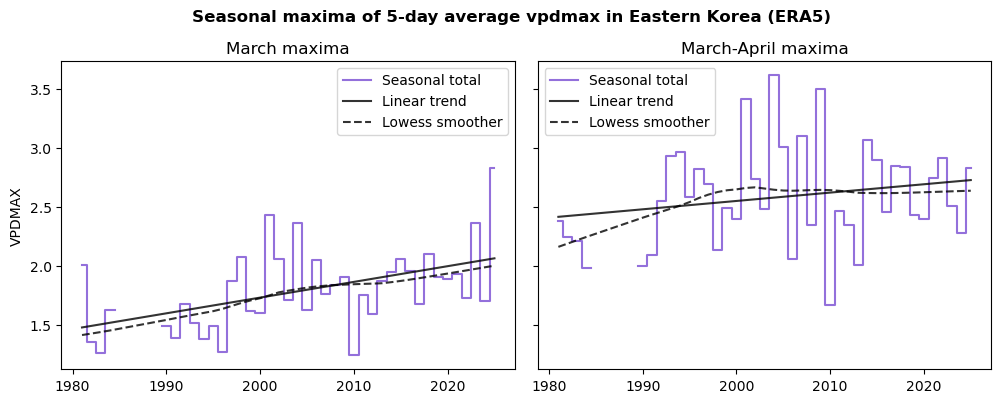

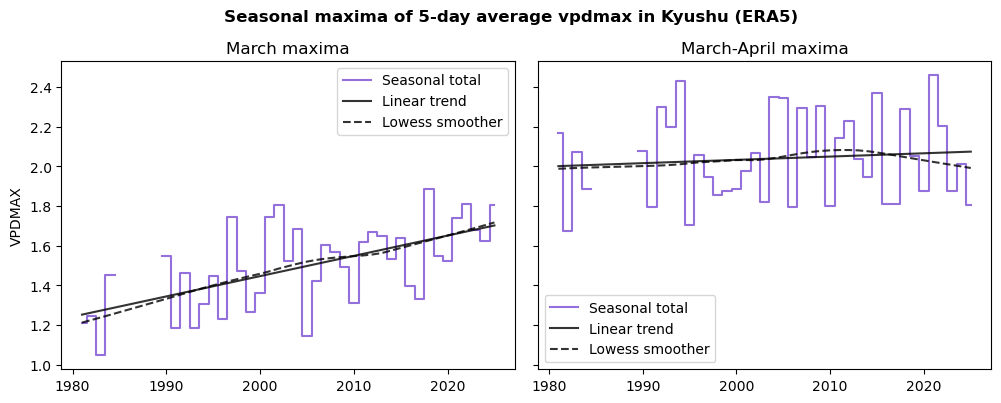

In [127]:
hdwi = xr.open_dataset("data/hdwi_era5land_198101-202503.nc")

varnm = "vpdmax"
col = {"hdwi" : "firebrick", "tasmax" : "tab:orange", "vpdmax" : "mediumpurple", "sfcWindmax" : "darkmagenta"}[varnm]

for rnm in ["Korea", "Eastern Korea", "Kyushu"]:

    sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
    rm = regionmask.mask_geopandas(sf, hdwi.lon, hdwi.lat)
    hdwi_ts = hdwi.where(rm == 0, drop = True).mean(["lat", "lon"]).load()

    hdwi5day_m = hdwi_ts.rolling(time = 5).mean().sel(time = hdwi_ts.time.dt.month.isin([3])).resample(time = "AS-MAR").max()
    hdwi5day_ma = hdwi_ts.rolling(time = 5).mean().sel(time = hdwi_ts.time.dt.month.isin([3,4])).resample(time = "AS-MAR").max()

    hdwi5day_ma = hdwi5day_ma.assign_coords(time = hdwi5day_ma.time.dt.year).rename(time = "year").to_dataframe()
    hdwi5day_m = hdwi5day_m.assign_coords(time = hdwi5day_m.time.dt.year).rename(time = "year").to_dataframe()

    # suspiciously low value so will remove
    hdwi5day_ma.loc[1985,["vpdmax", "hdwi"]] = np.nan
    hdwi5day_m.loc[1985,["vpdmax", "hdwi"]] = np.nan

    hdwi5day_ma.to_csv("ts/hdwi-vars_rx5day-ma_"+"-".join(rnm.lower().split(" "))+"_era5land.csv")
    hdwi5day_m.to_csv("ts/hdwi-vars_rx5day-m_"+"-".join(rnm.lower().split(" "))+"_era5land.csv")

    fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = True)
    plt.subplots_adjust(wspace = 0.05)

    for i in range(2):
        ax = axs[i]
        ts = [hdwi5day_m, hdwi5day_ma][i][[varnm]]
        ttl = ["March maxima", "March-April maxima"][i]

        ts[varnm].plot(ax = axs[i], drawstyle = "steps-mid", color = col)
        ax.set_xlabel("")
        ax.set_ylabel(varnm.upper())
        ax.set_title(ttl)

        ts = ts.dropna(axis = 0, how = "all")

        xyline(ts.index, ts[varnm].values, ax = ax, color = "k", alpha = 0.8)
        ax.plot(ts.index, lowess(ts[varnm].values, ts.index)[:,1], color = "k", ls = "--", alpha = 0.8)
        ax.legend(["Seasonal total", "Linear trend", "Lowess smoother"])

    plt.suptitle("Seasonal maxima of 5-day average "+varnm+" in "+rnm+" (ERA5)", fontweight = "bold", y = 1.01)
    plt.savefig("fig/qtrend_"+varnm+"_"+"-".join(rnm.lower().split(" "))+"_era5")

### Precip - Jan-March mean

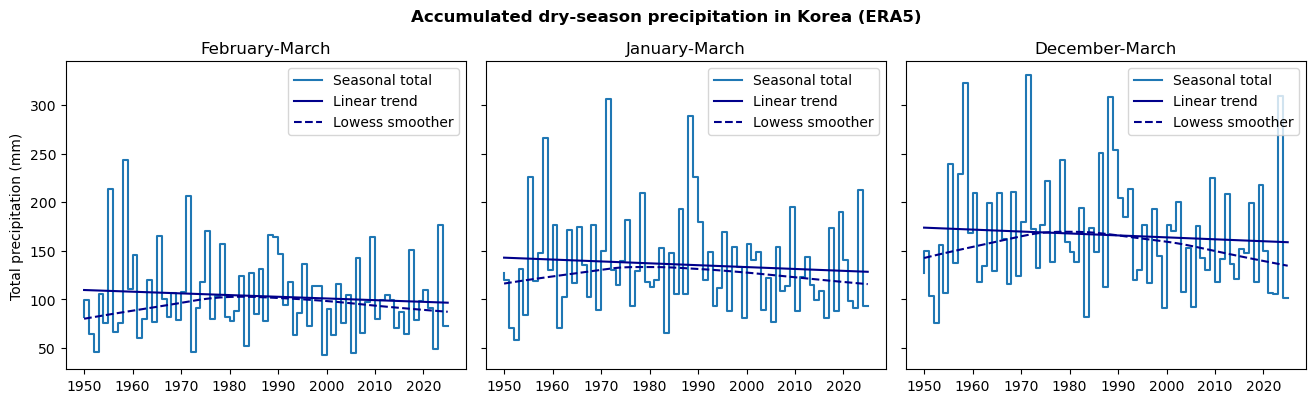

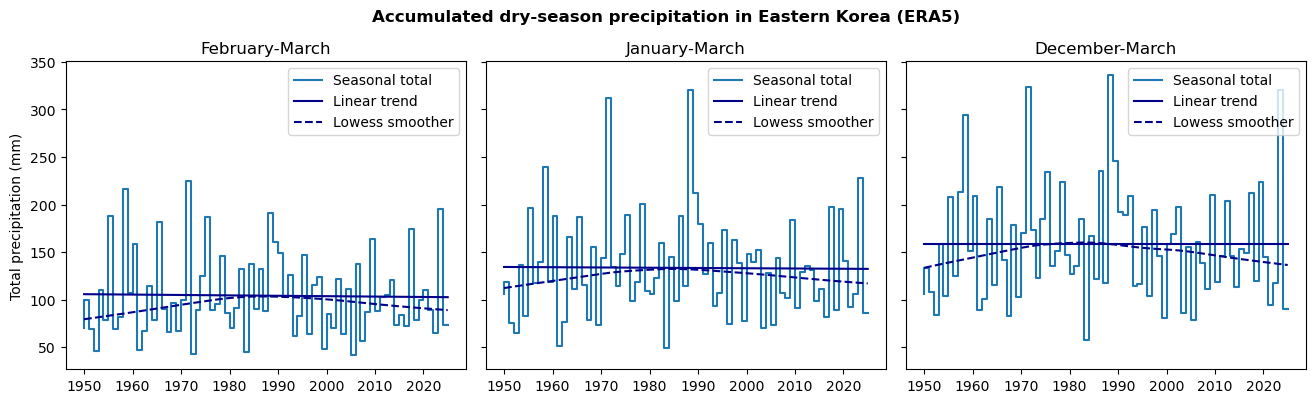

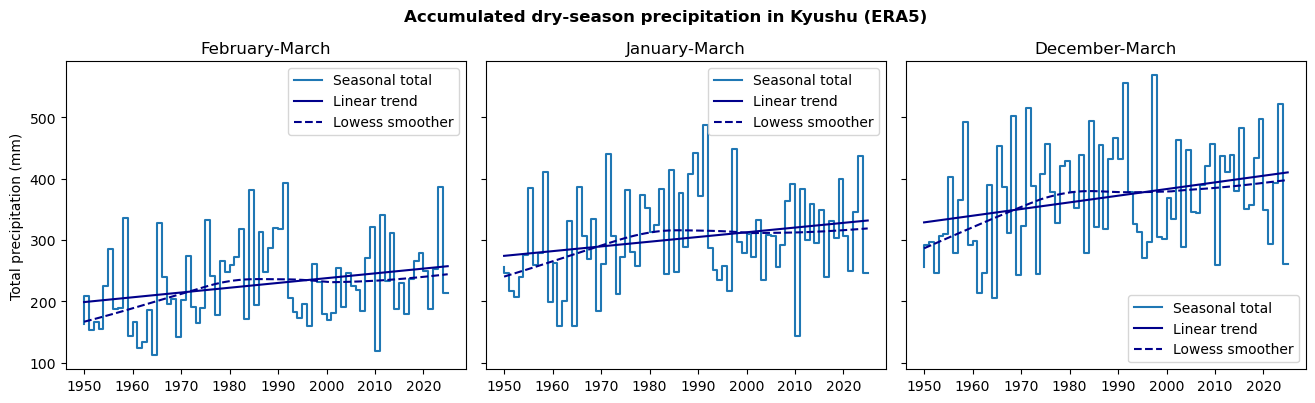

In [12]:
pr = xr.open_dataset("data/era5_tp_daily_extended_125-146E_30-46N.nc").tp

for rnm in ["Korea", "Eastern Korea", "Kyushu"]:

    sf = {"Korea" : sf_korea, "Eastern Korea" : sf_ekorea, "Kyushu" : sf_kyushu}[rnm]
    rm = regionmask.mask_geopandas(sf, pr.lon, pr.lat)
    pr_ts = pr.where(rm == 0, drop = True).mean(["lat", "lon"]).load()

    pr_fm = pr_ts.sel(time = pr_ts.time.dt.month.isin([2,3])).resample(time = "AS-JAN").sum()
    pr_jfm = pr_ts.sel(time = pr_ts.time.dt.month.isin([1,2,3])).resample(time = "AS-JAN").sum()
    pr_djfm = pr_ts.sel(time = pr_ts.time.dt.month.isin([12,1,2,3])).resample(time = "AS-APR", label = "right").sum()

    pr_fm = pr_fm.assign_coords(time = pr_fm.time.dt.year).rename(time = "year").to_dataframe()
    pr_fm.to_csv("ts/pr_fm_"+"-".join(rnm.lower().split(" "))+"_era5.csv")
    pr_jfm = pr_jfm.assign_coords(time = pr_jfm.time.dt.year).rename(time = "year").to_dataframe()
    pr_jfm.to_csv("ts/pr_jfm_"+"-".join(rnm.lower().split(" "))+"_era5.csv")
    pr_djfm = pr_djfm.assign_coords(time = pr_djfm.time.dt.year).rename(time = "year").to_dataframe()
    pr_djfm.to_csv("ts/pr_djfm_"+"-".join(rnm.lower().split(" "))+"_era5.csv")

    fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100, sharey = True)
    plt.subplots_adjust(wspace = 0.05)

    for i in range(3):
        ax = axs[i]
        ts = [pr_fm, pr_jfm, pr_djfm][i]
        ttl = ["February-March", "January-March", "December-March"][i]

        ts.plot(ax = axs[i], drawstyle = "steps", legend = None)
        ax.set_xlabel("")
        ax.set_ylabel("Total precipitation (mm)")
        ax.set_title(ttl)

        xyline(ts.index, ts.tp.values, ax = ax, color = "darkblue")
        ax.plot(ts.index, lowess(ts.tp.values, ts.index)[:,1], color = "darkblue", ls = "--")
        ax.legend(["Seasonal total", "Linear trend", "Lowess smoother"])

    plt.suptitle("Accumulated dry-season precipitation in "+rnm+" (ERA5)", fontweight = "bold", y = 1.01)
    plt.savefig("fig/qtrend_pr_"+"-".join(rnm.lower().split(" "))+"_era5")

# Event maps

## FWI

In [112]:
ev_dates = slice("2025-03-18", "2025-03-27")

px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])

In [113]:
fwi = xr.open_dataset("data/fwi_era5_201301-202501.nc")
rm_kr = regionmask.mask_geopandas(sf_korea, fwi.lon, fwi.lat)
rm_ekr = regionmask.mask_geopandas(sf_ekorea, fwi.lon, fwi.lat)
fwi_kr = fwi.where(rm_kr == 0, drop = True).mean(["lat", "lon"])
fwi_ekr = fwi.where(rm_ekr == 0, drop = True).mean(["lat", "lon"])

In [126]:
# climatological values to use as midpoints in plotting
fwi_clim = fwi.groupby("time.month")[3].sel(time = slice("2013", "2023")).mean("time")
kr_fwi_clim = fwi_clim.where(rm_kr == 0, drop = True).mean(["lat", "lon"])

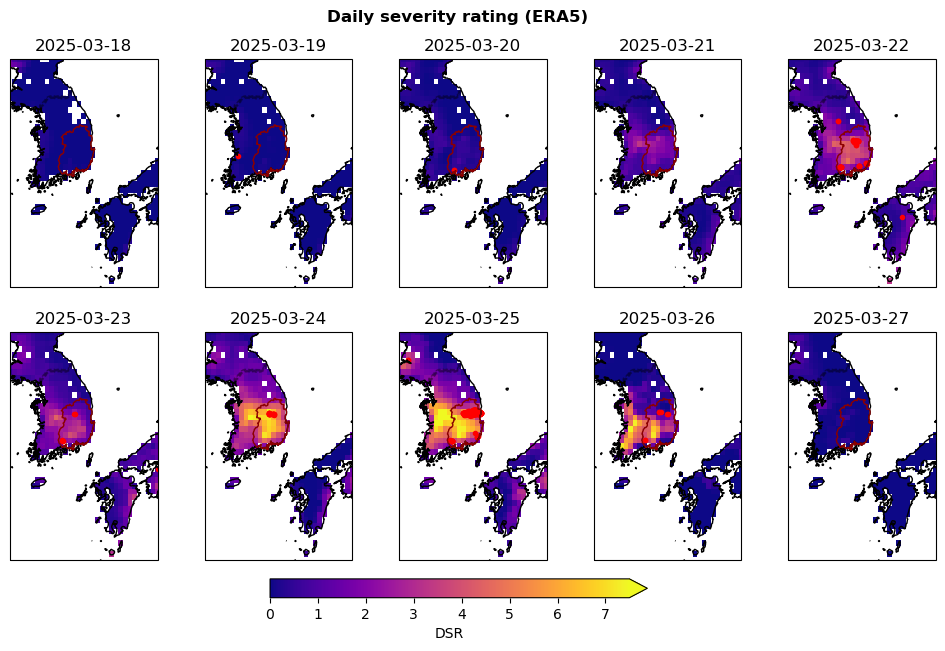

In [187]:
varnm = "dsr"

plot_kwargs = {"fwi" : {"cmap" : "plasma", "vmin" : 0, "vmax" : 25},
               "dsr" : {"cmap" : "plasma", "vmin" : 0, "vmax" : 7.5},
               "dc" : {"cmap" : "BrBG_r", "norm" : MidpointNormalize(vmin = 0, vmax = 100, midpoint = kr_fwi_clim.dc.values)},
               "dmc" : {"cmap" : "BrBG_r", "vmin" : 0, "vmax" : 30},
               "ffmc" : {"cmap" : "inferno", "vmin" : 0, "vmax" : 95},
               "isi" : {"cmap" : "inferno", "vmin" : 0, "vmax" : 20},
               "bui" : {"cmap" : "BrBG", "vmin" : 0, "vmax" : 30}
              }
title = {"fwi" : "Fire weather index", 
         "dsr" : "Daily severity rating",
         "dc" : "Drought code",
         "dmc" : "Duff moisture code",
         "ffmc" : "Fine fuel moisture code",
         "isi" : "Initial spread index",
         "bui" : "Build up index"}

nc = 5; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*2.5, nr*3.5), subplot_kw = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
plt.subplots_adjust(wspace = 0.02)

for i in range(10):
    ax = axs.flatten()[i]
    d = (pd.date_range(ev_dates.start, ev_dates.stop)[i]).strftime("%Y-%m-%d")
    
    cbar = fwi[varnm].sel(time = d).plot(ax = ax, add_colorbar = False, **plot_kwargs[varnm])
    
    if d in px.index:
        px_d = px.loc[d]
        ax.scatter(px_d.longitude, px_d.latitude, color = "red", marker = ".")
        
    ax.set_title(d)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.4)
    sf_ekorea.boundary.plot(ax = ax, color = "darkred", lw = 1)
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.035, pad = 0.035, label = varnm.upper(), extend = "max")
plt.suptitle(title[varnm]+" (ERA5)", fontweight = "bold", y = 0.95)

plt.savefig("fig/event-maps_"+varnm+"_era5")

## HDWI

In [80]:
vpd_clim = wrap_lon(xr.open_dataset(fpath+"era5-land_vpdmax_198101-202402.nc").vpdmax.sel(time = slice("1990","2020")))
wind_clim = wrap_lon(xr.open_dataset(fpath+"era5-land_sfcWindmax_198101-202402.nc").sfcWindmax.sel(time = slice("1990","2020")))
hdwi_clim = vpd_clim * wind_clim
hdwi_clim = hdwi_clim.groupby("time.month").mean()
vpd_clim = vpd_clim.groupby("time.month").mean()
wind_clim = wind_clim.groupby("time.month").mean()

vpd_2025 = wrap_lon(xr.open_dataset(fpath+"era5-land_vpdmax_202503.nc").vpdmax)
wind_2025 = wrap_lon(xr.open_dataset(fpath+"era5-land_sfcWindmax_202503.nc").sfcWindmax)
hdwi_2025 = vpd_2025 * wind_2025

In [81]:
vpd_clim = vpd_clim.assign_coords(longitude = vpd_2025.longitude, latitude = vpd_2025.latitude)
wind_clim = wind_clim.assign_coords(longitude = wind_2025.longitude, latitude = wind_2025.latitude)
hdwi_clim = hdwi_clim.assign_coords(longitude = hdwi_2025.longitude, latitude = hdwi_2025.latitude)

In [82]:
vpd_anom = vpd_2025 - vpd_clim.sel(month = 3)
wind_anom = wind_2025 - wind_clim.sel(month = 3)
hdwi_anom = hdwi_2025 - hdwi_clim.sel(month = 3)
hdwi_relanom = hdwi_anom / hdwi_clim.sel(month = 3) * 100

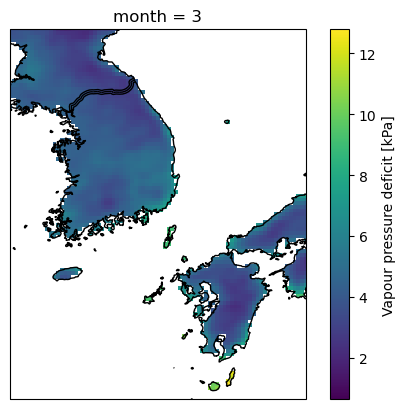

In [83]:
fig = hdwi_clim.sel(month = 3).plot(subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})

ax = fig.axes

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)

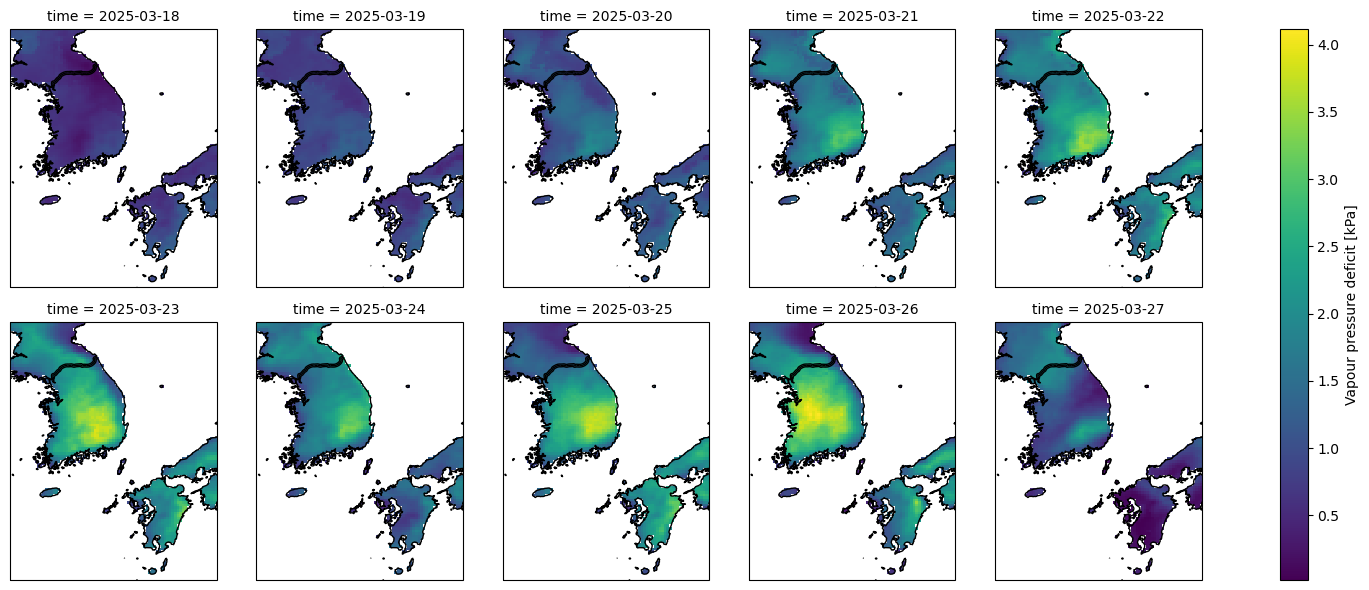

In [84]:
fig = vpd_2025.sel(time = ev_dates).plot(col = "time", col_wrap = 5, subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)

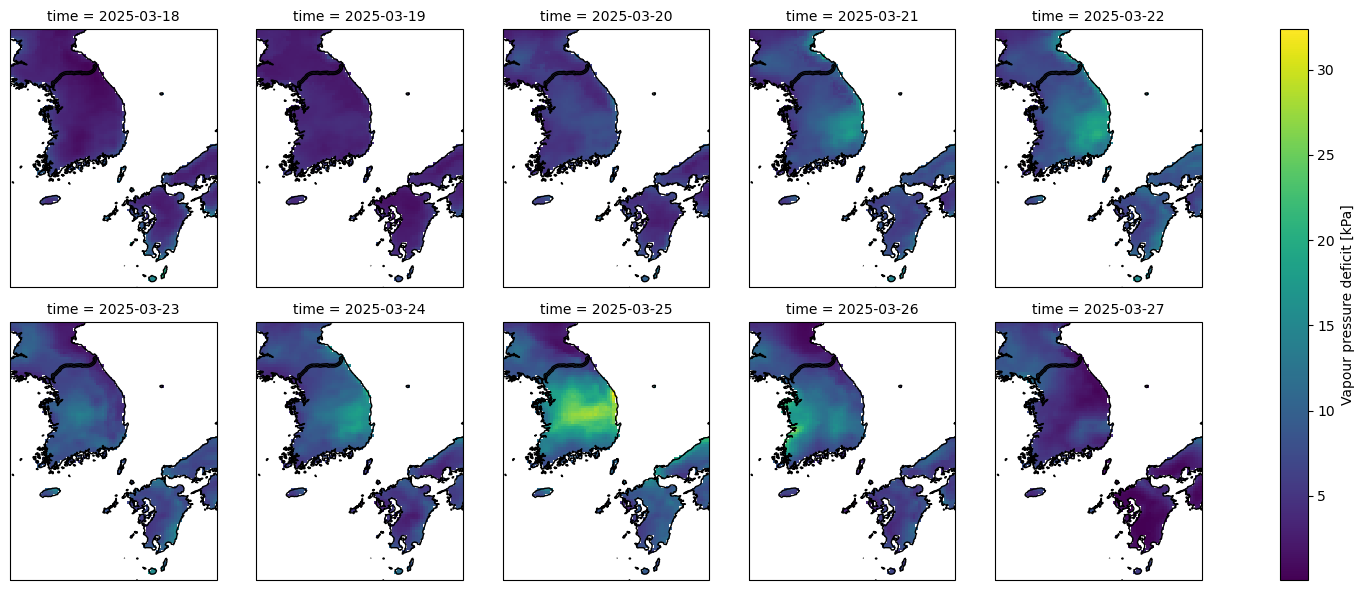

In [85]:
fig = hdwi_2025.sel(time = ev_dates).plot(col = "time", col_wrap = 5, subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)

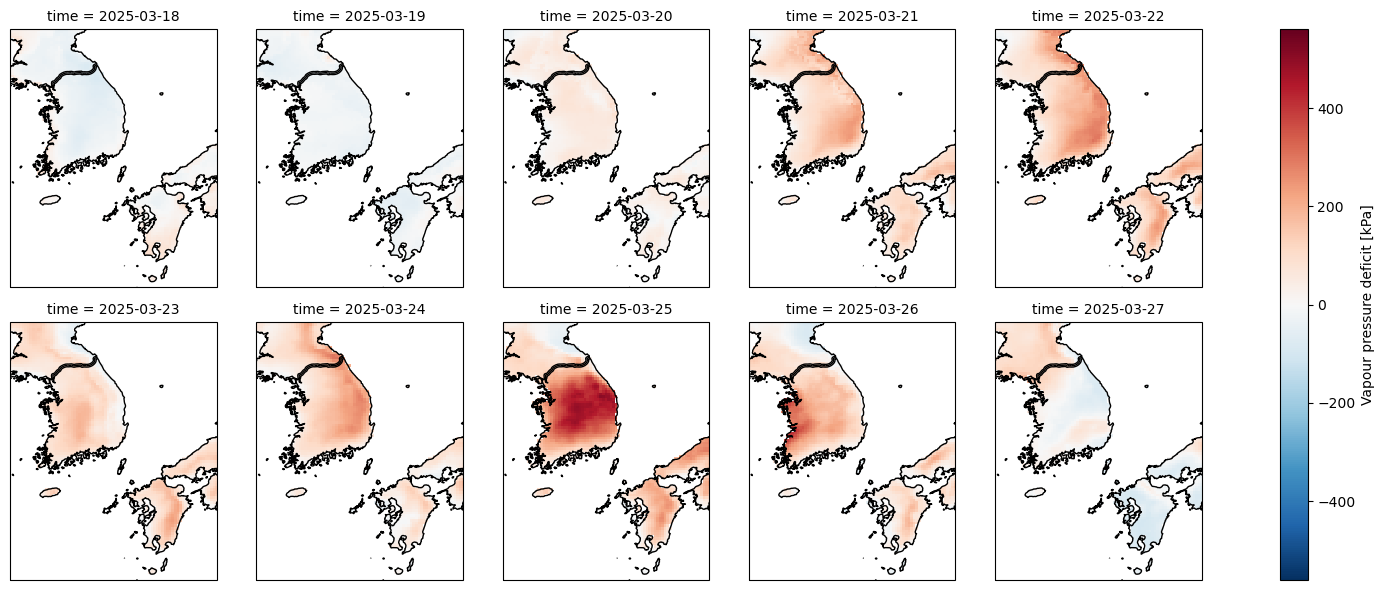

In [86]:
fig = hdwi_relanom.sel(time = ev_dates).plot(col = "time", col_wrap = 5, subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)

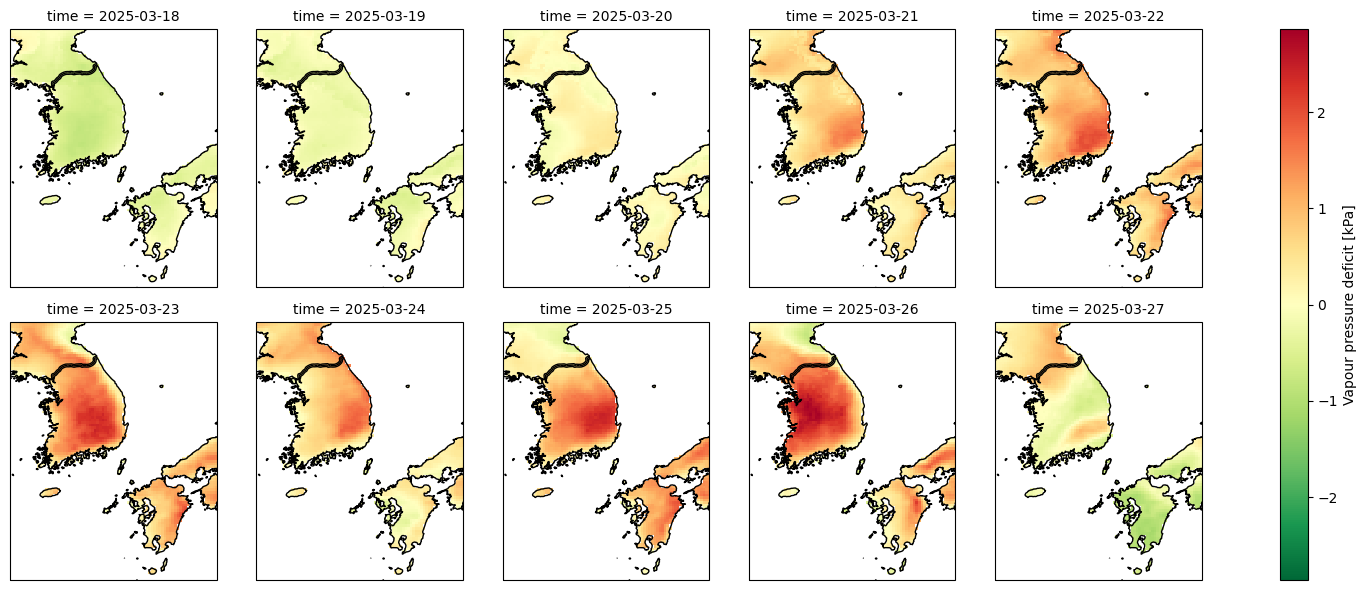

In [93]:
fig = vpd_anom.sel(time = ev_dates).plot(col = "time", col_wrap = 5, cmap = "RdYlGn_r", subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)

In [ ]:
fig = wind_anom.sel(time = ev_dates).plot(col = "time", col_wrap = 5, cmap = "PiYG_r", subplot_kws = {"projection" : mapproj, "extent": [xn,xx,yn,yx]})
axs = fig.axs.flatten()

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS)

# Sensitivity of VPD trend to calculation method

In [4]:
rnm = "kr"

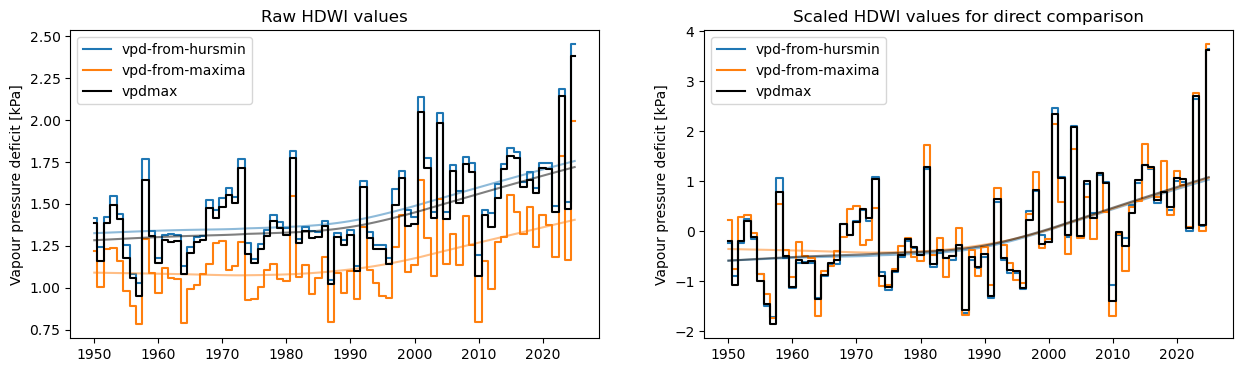

In [67]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 4), dpi = 100)
   
fl = sorted(glob.glob("daily-ts/vpd*"+rnm+".nc"))
for fnm in fl:
    ts = xr.open_dataset(fnm)
    ts = ts[list(ts.data_vars)[0]]
    
    varnm = fnm.split("/")[-1].split("_")[0]
    col = {"vpdmax" : "k", "vpd-from-hursmin" : "tab:blue", "vpd-from-maxima" : "tab:orange", "vpd-from-monthly" : "tab:green"}[varnm]
    
    vpd5x = ts.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max()
    vpd5x = vpd5x.assign_coords(time = vpd5x.time.dt.year).rename(time = "year")
    
    vpd5x.plot(ax = axs[0], drawstyle = "steps-mid", label = varnm, color = col)
    axs[0].plot(vpd5x.year.values, lowess(vpd5x.values, vpd5x.year.values)[:,1], color = col, alpha = 0.5)
    
    scale(vpd5x).plot(ax = axs[1], drawstyle = "steps-mid", color = col, label = varnm)
    axs[1].plot(vpd5x.year.values, lowess(scale(vpd5x).values, vpd5x.year.values)[:,1], color = col, alpha = 0.5)
    

for ax in axs:
    ax.set_xlabel(""); ax.legend()

axs[0].set_title("Raw HDWI values")
axs[1].set_title("Scaled HDWI values for direct comparison")

plt.savefig("fig/compare-vpd-methods_"+rnm+".png")

# Change in seasonal cycle

In [5]:
rnm = "kr"

In [25]:
ts_list = { varnm : xr.open_dataset("daily-ts/"+varnm+"_era5land_195001-202503_"+rnm+".nc") for varnm in ["tasmax", "hursmin", "sfcWindmax", "vpdmax", "hdwi-from-vpdmax"]}
ts_list["pr (ERA5)"] = xr.open_dataset("daily-ts/pr_era5_195001-202503.nc")

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(len(days)) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(len(days)) if (days[i].day) == 15]

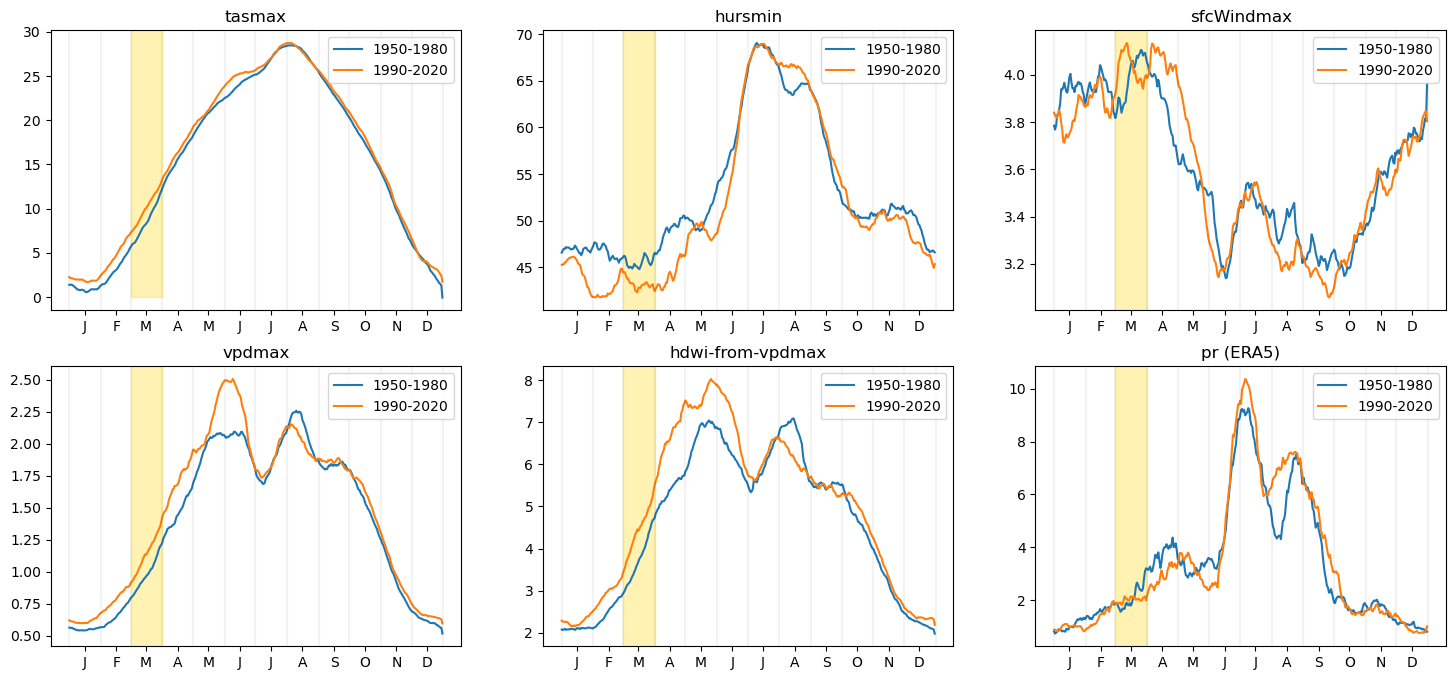

In [38]:
nc = 3; nr = 2
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 6, nr * 4), dpi = 100, sharex = False)

for i in range(len(ts_list)):
    ax = axs.flatten()[i]
    varnm = list(ts_list.keys())[i]
    
    ts = ts_list[varnm]
    ts = ts[list(ts.data_vars)[0]].rolling(time = 15, center = True).mean()
    ax.set_title(varnm)
    
    sc_5080 = ts.sel(time = slice("1950","1980")).groupby("time.dayofyear").mean()
    sc_9020 = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").mean()
    
    sd_5080 = ts.sel(time = slice("1950","1980")).groupby("time.dayofyear").std()
    sd_9020 = ts.sel(time = slice("1990","2020")).groupby("time.dayofyear").std()
    
    ax.plot(sc_5080, color = "tab:blue", label = "1950-1980")
    ax.plot(sc_9020, color = "tab:orange", label = "1990-2020")
#     ax.fill_between(x = sc_5080.dayofyear.values, y1 = sc_5080 - 2*sd_5080, y2 = sc_5080 + 2*sd_5080, color = "tab:blue", alpha = 0.1)
#     ax.fill_between(x = sc_9020.dayofyear.values, y1 = sc_9020 - 2*sd_9020, y2 = sc_9020 + 2*sd_9020, color = "tab:orange", alpha = 0.1)
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(len(days)) if (days[x].day) == 1]
    
    ax.legend()
    
    ylim = ax.get_ylim()
    d_start = ts.sel(time = "2025-03-01").time.dt.dayofyear
    ax.add_patch(Rectangle((d_start, 0), 31, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
plt.savefig("fig/compare-seasonal-cycle_"+rnm+".png")

# Stations vs nearest gridpoint

In [3]:
fl = sorted(glob.glob("data/stations/*.csv"))
stn_meta = pd.read_csv("station-metadata.csv", index_col = 0)

In [9]:
varnm = "vpd"

long_varnm = {"hdwi" : "hdwi-from-vpdmax", "tasmax" : "tasmax", "sfcWindmax" : "sfcWindmax", "hursmin" : "hursmin", "pr" : "pr-monthly", "vpd" : "vpdmax"}[varnm]
ttl_varnm = {"hdwi" : "HDWI5x", "tasmax" : "Tx5x", "sfcWindmax" : "sfcWindmax5x", "hursmin" : "hursmin5n", "pr" : "pr-fm", "vpd" : "vpd"}[varnm]

ds = xr.open_dataset("data/era5land/"+long_varnm+"_era5land_195001-202503.nc")
ds = ds[list(ds.data_vars)[0]]

if varnm == "hursmin" : 
    ds = ds.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").min().dropna("time", "all")
elif varnm == "pr" : 
    ds = convert_units_to(ds, "mm/month").sel(time = ds.time.dt.month.isin([2,3])).resample(time = "AS-MAR").sum().dropna("time", "all")
else: 
    ds = ds.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max().dropna("time", "all")

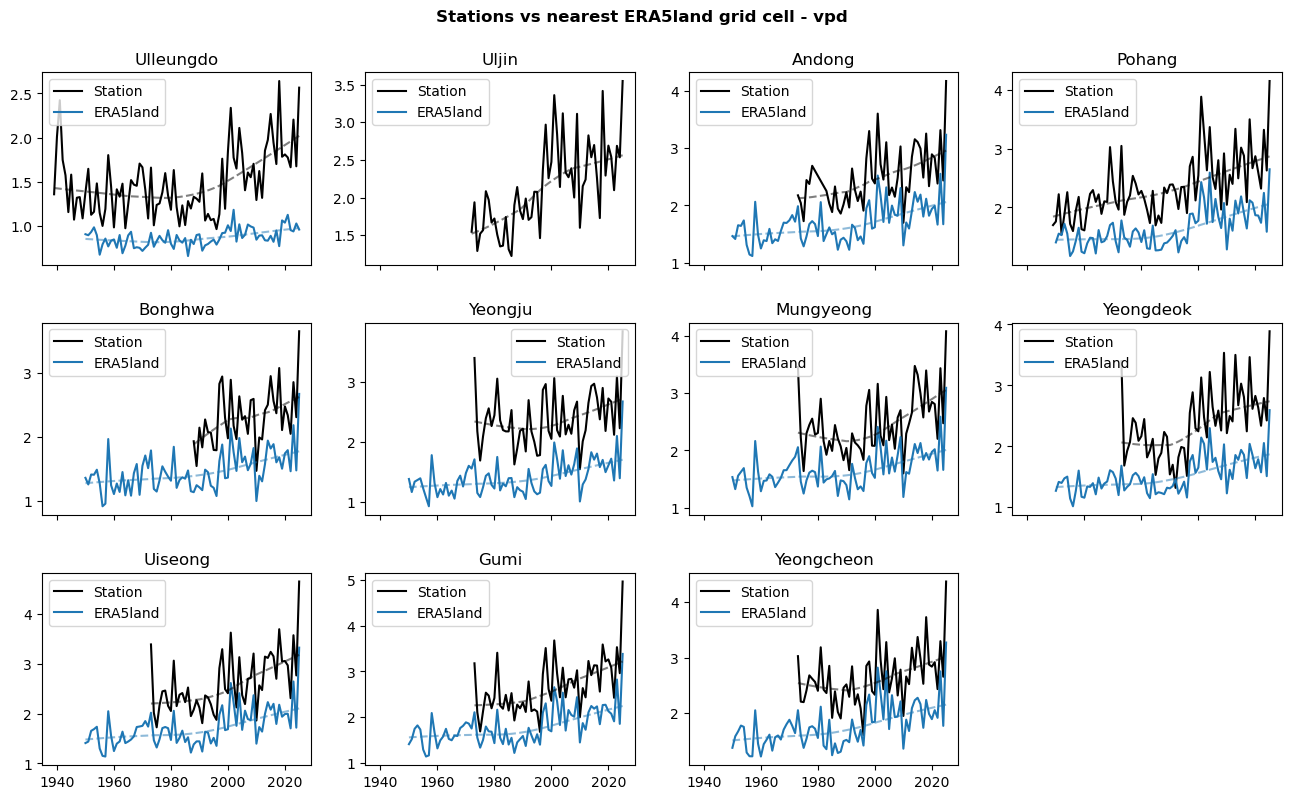

In [10]:
nc = 4; nr = 3
fig, axs= plt.subplots(ncols = nc, nrows = nr, figsize = (nc * 4, nr * 3), dpi = 100, sharex = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(len(fl)):
    fnm = fl[i]
    ax = axs.flatten()[i]
    
    stn_data = stn_meta.loc[int(fnm.split("_")[1])]
    
    ts = pd.read_csv(fl[i], index_col = "date", parse_dates = ["date"])
    if varnm == "hursmin" : 
        ts5x = ts[varnm].rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").min().dropna(axis = 0, how = "any")
    elif varnm == "pr" : 
        ts5x = ts[varnm].loc[ts.index.month.isin([2,3])].resample("AS-MAR").sum().dropna(axis = 0, how = "any")
    else: 
        ts5x = ts[varnm].rolling(5).mean().loc[ts.index.month.isin([3])].resample("AS-MAR").max().dropna(axis = 0, how = "any")
    
    era5 = ds.sel(longitude = stn_data.lon, latitude = stn_data.lat, method = "nearest")
    era5 = era5.assign_coords(time = era5.time.dt.year).rename(time = "year")
    
    ax.plot(ts5x.index.year, ts5x, color = "k")
    ax.plot(era5.year, era5, color = "tab:blue")
    ax.plot(ts5x.index.year, lowess(ts5x.values, ts5x.index.year.values)[:,1], ls = "--", color = "k", alpha= 0.5)
    if not np.isnan(era5).all(): ax.plot(era5.year, lowess(era5.values, era5.year.values)[:,1], ls = "--", color = "tab:blue", alpha= 0.5)
    ax.set_title(stn_data.stn_name)
    
    ax.legend(["Station", "ERA5land"])
    
for i in range(len(fl), nc*nr): axs.flatten()[i].set_axis_off()
plt.suptitle("Stations vs nearest ERA5land grid cell - "+ttl_varnm, fontweight = "bold", y = 0.95)
plt.savefig("fig/stn-vs-era5land_"+varnm+".png")

# Correlations between variables

In [18]:
ds = xr.merge([xr.open_dataset("daily-ts/"+varnm+"_era5land_195001-202503_kr.nc") for varnm in ["tasmax", "dewmax", "vpdmax", "hursmin", "sfcWindmax", "hdwi-from-vpdmax"]]).to_pandas()

In [ ]:
axes = pd.plotting.scatter_matrix(ds, alpha=0.1, figsize = (10,10), diagonal = "kde")
corr = ds.corr().to_numpy()

for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center')
    
plt.suptitle("Correlations between daily vars (KR timeseries) - ERA5land", fontweight = "bold", y = 0.975)
plt.savefig("fig/correlation-between-daily-vars_kr.png")